# SHAP

In [1]:
import numpy as np
import scipy as sp
import scipy.cluster
import matplotlib.pyplot as plt
import xgboost
import shap
import pandas as pd
import seaborn as sns
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, r2_score
shap.initjs()
print(mpl.__version__)

3.5.2


# TreeSHAP explain

from https://medium.com/analytics-vidhya/shap-part-3-tree-shap-3af9bcd7cd9b

## SHAP value calculation

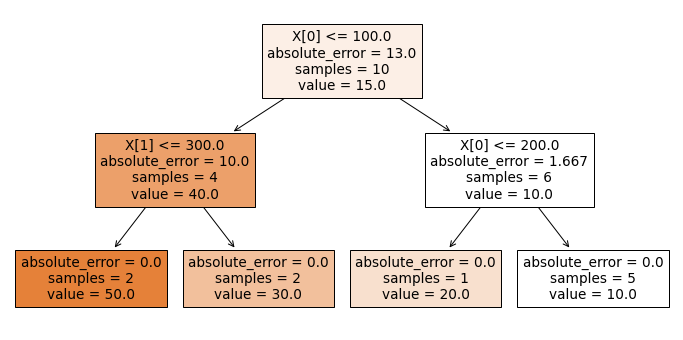

In [46]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

np.random.seed(100)
X_train = pd.DataFrame({
    'x':[206]*5 + [194] + [6]*4,
    'y': list(np.random.randint(100, 400, 6)) + [299, 299, 301, 301],
    'z': list(np.random.randint(100, 400, 10))
})
y_train = pd.Series([10]*5 + [20] + [50]*2 + [30]*2)
y_train.name = 't'
tree_model = DecisionTreeRegressor(criterion='absolute_error', max_depth=2, min_samples_leaf=1, min_samples_split=2, random_state=100)
tree_model.fit(X=X_train, y=y_train)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
annots = plot_tree(tree_model, filled=True, ax=ax)
plt.show()

In [505]:
X_test = pd.DataFrame({'x': [150], 'y': [75], 'z': [200]})

In [545]:
import itertools

def iteration(iterable):
    s = list(iterable)
    return [list(itertools.permutations(s, r))[0] for r in range(1, len(s)+1)]

possible_players = list(itertools.permutations(['x', 'y', 'z']))

value_null = y_train.mean()
# f(x) given x = 150
value_x = 20.0
# f(y) given y = 75
value_y = 4/10 * 50 + 6/10 * ( 1/6*20 + 5/6*10 )
# f(z) given z = 200
value_z = value_null
vs = {'null': value_null, 'x': value_x, 'y': value_y, 'z': value_z}

all_phis = {}
all_preds = {}
all_preds[()] = value_null
for pc in possible_players:
    phis = []
    print(f'{pc}')
    for ps in iteration(pc):
        # prediction
        if 'x' in ps:
            pred = vs['x']
        elif 'y' in ps:
            pred = vs['y']
        else:
            pred = vs['z']
        
        if len(ps) == 1:
            phi = pred - vs['null']
            print(f'phi = {ps} - null = {pred} - {vs["null"]} = {phi}')
        elif len(ps) == 2:
            phi = pred - pred_prev
            print(f'phi = {ps} - {iteration(pc)[0]} = {pred} - {pred_prev} = {phi}')
        else:
            phi = pred - pred_prev
            print(f'phi = {ps} - {iteration(pc)[1]} = {pred} - {pred_prev} = {phi}')
        
        all_preds[tuple(sorted(ps))] = pred
        phis.append(float(phi))
        pred_prev = pred
    all_phis[pc] = phis

('x', 'y', 'z')
phi = ('x',) - null = 20.0 - 23.0 = -3.0
phi = ('x', 'y') - ('x',) = 20.0 - 20.0 = 0.0
phi = ('x', 'y', 'z') - ('x', 'y') = 20.0 - 20.0 = 0.0
('x', 'z', 'y')
phi = ('x',) - null = 20.0 - 23.0 = -3.0
phi = ('x', 'z') - ('x',) = 20.0 - 20.0 = 0.0
phi = ('x', 'z', 'y') - ('x', 'z') = 20.0 - 20.0 = 0.0
('y', 'x', 'z')
phi = ('y',) - null = 27.0 - 23.0 = 4.0
phi = ('y', 'x') - ('y',) = 20.0 - 27.0 = -7.0
phi = ('y', 'x', 'z') - ('y', 'x') = 20.0 - 20.0 = 0.0
('y', 'z', 'x')
phi = ('y',) - null = 27.0 - 23.0 = 4.0
phi = ('y', 'z') - ('y',) = 27.0 - 27.0 = 0.0
phi = ('y', 'z', 'x') - ('y', 'z') = 20.0 - 27.0 = -7.0
('z', 'x', 'y')
phi = ('z',) - null = 23.0 - 23.0 = 0.0
phi = ('z', 'x') - ('z',) = 20.0 - 23.0 = -3.0
phi = ('z', 'x', 'y') - ('z', 'x') = 20.0 - 20.0 = 0.0
('z', 'y', 'x')
phi = ('z',) - null = 23.0 - 23.0 = 0.0
phi = ('z', 'y') - ('z',) = 27.0 - 23.0 = 4.0
phi = ('z', 'y', 'x') - ('z', 'y') = 20.0 - 27.0 = -7.0


In [521]:
data = {'x': [], 'y': [], 'z': []}
for ks, vs in all_phis.items():
    for k, v in zip(*(ks, vs)):
        data[k].append(v)

df_all_phis = pd.DataFrame(data)
df_all_phis

,x,y,z
0,-3.0,0.0,0.0
1,-3.0,0.0,0.0
2,-7.0,4.0,0.0
3,-7.0,4.0,0.0
4,-3.0,0.0,0.0
5,-7.0,4.0,0.0


In [599]:
shap_values = df_all_phis.mean(0).values
shap_values

array([-5.,  2.,  0.])

In [595]:
explainer = shap.TreeExplainer(tree_model)
shap_values2 = explainer.shap_values(X_test)
shap_values2

array([[-5.,  2.,  0.]])

In [596]:
shap.force_plot(explainer.expected_value, shap_values2[0,:], X_test.iloc[0,:])

## Feature Interaction in SHAP

https://christophm.github.io/interpretable-ml-book/shap.html#shap-interaction-values

https://github.com/slundberg/shap/issues/608

https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html?highlight=pred_interactions%20#using-native-interface

$$\phi_{i,j}=\sum_{S\subseteq M \setminus\{i,j\}}\frac{\vert S\vert !(\vert M\vert -\vert S\vert -2)!}{2(\vert M\vert -1)!}\delta_{ij}(S)$$

where $i\neq j$ and 

$$\delta_{ij}(S)=\hat{f}_x(S\cup\{i,j\})-\hat{f}_x(S\cup\{i\})-\hat{f}_x(S\cup\{j\})+\hat{f}_x(S)$$

* $M$: total features set

In [628]:
def powerset(iterable):
    s = list(iterable)
    return list(itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1)))

def set_minus(x, y):
    if not isinstance(x, set):
        x = set(sorted(x))
    if not isinstance(y, set):
        y = set(sorted(y))
    return tuple(x - y)   

def set_plus(x, y):
    if not isinstance(x, set):
        x = set(sorted(x))
    if not isinstance(y, set):
        y = set(sorted(y))
    return tuple(x.union(y))   

def interaction_value(all_preds, cols, interactions):
    phi = 0
    fact = sp.special.factorial
    M = len(cols)
    print(f'{interactions}')
    for s in powerset(set_minus(cols, interactions)):
        S = len(s)
        prob = (fact(S) * fact(M-S-2)) / (2 * fact(M-1))
        s_with_ij = set_plus(s, interactions)
        s_with_i = set_plus(s, interactions[0])
        s_with_j = set_plus(s, interactions[1])
        s_ij = (all_preds[s_with_ij] - all_preds[s_with_i] - all_preds[s_with_j] + all_preds[s])
        phi += s_ij * prob
        print(f'>> prob: {prob}')
        print(f'>> s_ij: f({s_with_ij}) - f({s_with_i}) - f({s_with_j}) + f({s}) = {s_ij}')
    return phi

In [629]:
cols = ['x', 'y', 'z']
all_preds

{(): 23.0,
 ('x',): 20.0,
 ('x', 'y'): 20.0,
 ('x', 'y', 'z'): 20.0,
 ('x', 'z'): 20.0,
 ('y',): 27.0,
 ('y', 'z'): 27.0,
 ('z',): 23.0}

In [649]:
interaction_values = np.zeros([len(cols)]*2)
for interactions, idxes in zip(itertools.combinations(cols, 2), itertools.combinations(range(len(cols)), 2)):
    r, c = idxes
    iv = interaction_value(all_preds, cols, interactions)
    interaction_values[r, c] = iv
    interaction_values[c, r] = iv

r, c = np.tril_indices(len(cols), -1)
interactions_total = interaction_values[r, c].sum()
for i in shap_values.nonzero():  # to fit the missingness
    interaction_values[i, i] = shap_values[i] - interactions_total

('x', 'y')
>> prob: 0.25
>> s_ij: f(('x', 'y')) - f(('x',)) - f(('y',)) + f(()) = -4.0
>> prob: 0.25
>> s_ij: f(('x', 'y', 'z')) - f(('x', 'z')) - f(('y', 'z')) + f(('z',)) = -4.0
('x', 'z')
>> prob: 0.25
>> s_ij: f(('x', 'z')) - f(('x',)) - f(('z',)) + f(()) = 0.0
>> prob: 0.25
>> s_ij: f(('x', 'y', 'z')) - f(('x', 'y')) - f(('y', 'z')) + f(('y',)) = 0.0
('y', 'z')
>> prob: 0.25
>> s_ij: f(('y', 'z')) - f(('y',)) - f(('z',)) + f(()) = 0.0
>> prob: 0.25
>> s_ij: f(('x', 'y', 'z')) - f(('x', 'y')) - f(('x', 'z')) + f(('x',)) = 0.0


In [652]:
# diag = main effect
# non-diag = interaction values
interaction_values

array([[-3., -2.,  0.],
       [-2.,  4.,  0.],
       [ 0.,  0.,  0.]])

In [651]:
shap.TreeExplainer(tree_model).shap_interaction_values(X_test)

array([[[-3., -2.,  0.],
        [-2.,  4.,  0.],
        [ 0.,  0.,  0.]]])

### What does these mean?

# Example: NHANES I

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/NHANES%20I%20Survival%20Model.html?highlight=shap_interaction_values#SHAP-Interaction-Value-Summary-Plot

In [2]:
# X, y = shap.datasets.nhanesi()
# X_display,y_display = shap.datasets.nhanesi(display=True) # human readable feature values

# xgb_full = xgboost.DMatrix(X, label=y)

# # create a train/test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
# xgb_train = xgboost.DMatrix(X_train, label=y_train)
# xgb_test = xgboost.DMatrix(X_test, label=y_test)

## Dataset

### Data Set Information:

Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))

Prediction task is to determine whether a person makes over 50K a year.


### Attribute Information:

**Listing of attributes:**

target: >50K, <=50K.

inputs:
- age: continuous.
- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- fnlwgt: continuous.
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- education-num: continuous.
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- sex: Female, Male.
- capital-gain: continuous.
- capital-loss: continuous.
- hours-per-week: continuous.
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [2]:
# https://archive.ics.uci.edu/ml/datasets/adult

seed = 7
X_display, y_display = shap.datasets.adult(display=True)
X, y = shap.datasets.adult(display=False)
# Fixing some types
y = y.astype(np.uint8)
y_display = y_display.astype(np.uint8)

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

params = {
    'eta': 0.02,
    'max_depth': 3,
    'objective': 'binary:logistic',
    'subsample': 0.5,
    'seed': seed
}
model = xgboost.train(params, xgb_train, 5000, evals=[(xgb_test, "test")], verbose_eval=1000)

[0]	test-logloss:0.68230
[1000]	test-logloss:0.28195
[2000]	test-logloss:0.27875
[3000]	test-logloss:0.27846
[4000]	test-logloss:0.27930
[4999]	test-logloss:0.28015


In [3]:
y_pred = (model.predict(xgb_test) >= 0.5).astype(np.uint8)
print(f'# of train data: {xgb_train.num_row()}')
print(f'# of train data: {xgb_test.num_row()}')
print('Classification Report:')
print(classification_report(y_true=y_test, y_pred=y_pred))

# of train data: 26048
# of train data: 6513
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4951
           1       0.78      0.66      0.71      1562

    accuracy                           0.87      6513
   macro avg       0.84      0.80      0.82      6513
weighted avg       0.87      0.87      0.87      6513



In [4]:
idx = np.arange(len(y_test))
sample_idx = np.concatenate((idx[y_test == 0][:5], idx[y_test == 1][:5]))

In [5]:
explainer = shap.TreeExplainer(model, data=X_test)
shap_values = explainer.shap_values(X_test.iloc[sample_idx, :])

In [6]:
i = sample_idx[0]
shap.force_plot(explainer.expected_value, shap_values[i], X_display.iloc[i, :])

In [7]:
i = sample_idx[6]
shap.force_plot(explainer.expected_value, shap_values[i], X_display.iloc[i, :])

calculate all shap values + shape interaction values

In [16]:
shap_values = shap.TreeExplainer(model).shap_values(X_test)
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_test)
print(np.unique(y_test, return_counts=True))

(array([0, 1], dtype=uint8), array([4951, 1562], dtype=int64))


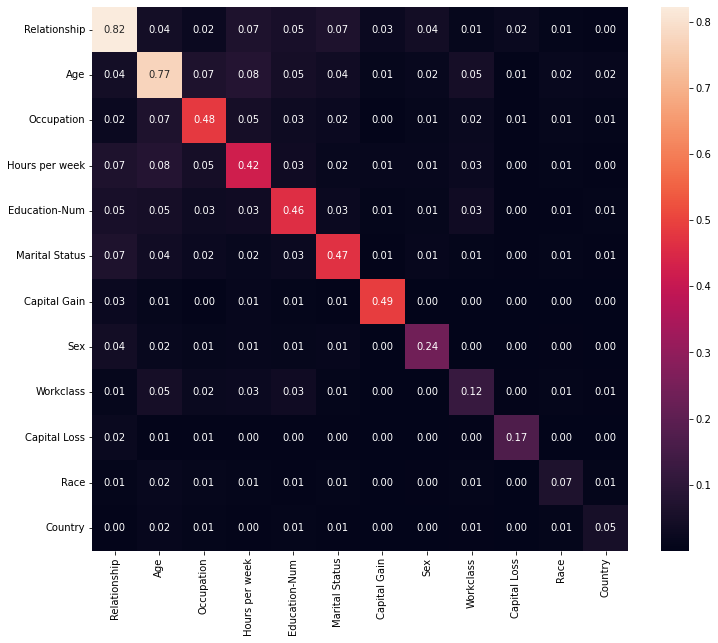

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

siv = shap_interaction_values.copy()
for i in range(len(siv)):
    siv[i][np.diag_indices(12, ndim=2)] = 0.0

r, c = np.diag_indices(12)
siv[:, r, c] = shap_values

# due to calcuate absolute value, it can only measure the magnitude not the directions
tmp = np.abs(siv).sum(0)
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
sns.heatmap(data=pd.DataFrame(tmp2/len(siv), index=X_test.columns[inds], columns=X_test.columns[inds]), annot=True, fmt='.2f', ax=ax)
plt.show()

In [27]:
shap_values.round(2)

array([[ 0.06,  0.05, -0.17, ..., -0.42, -0.2 , -0.  ],
       [ 0.72,  0.38,  0.5 , ..., -0.05,  0.69,  0.01],
       [-2.  , -0.07, -0.06, ..., -0.08, -0.28, -0.01],
       ...,
       [-4.3 ,  0.13,  0.09, ..., -0.07, -1.48, -0.02],
       [-1.6 , -0.19, -0.33, ..., -0.07, -0.29, -0.24],
       [ 0.52,  0.04,  0.09, ..., -0.08, -0.06,  0.02]], dtype=float32)

In [10]:
def batch_tril_indexing(A, dim=1, cols=None):
    rt_pd = False if cols is None else True
    k = A.shape[dim]
    r, c = np.tril_indices(k, -1)
    if rt_pd:
        cs = list(zip(*(cols[r], cols[c])))
        return pd.DataFrame(A[:, r, c], columns=cs)
    else:
        return A[:, r, c]

In [24]:
shap_values.shape

(6513, 12)

In [76]:
dim = 1
A = np.random.randint(0, 9, size=(2, 3, 3))
k = A.shape[dim]
r, c = np.tril_indices(k, -1)
A

array([[[4, 5, 5],
        [8, 4, 3],
        [5, 3, 1]],

       [[2, 3, 3],
        [3, 5, 5],
        [1, 5, 4]]])

In [11]:
siv_dense = batch_tril_indexing(siv, dim=1, cols=X_test.columns)
siv_dense

,"(Workclass, Age)","(Education-Num, Age)","(Education-Num, Workclass)","(Marital Status, Age)","(Marital Status, Workclass)","(Marital Status, Education-Num)","(Occupation, Age)","(Occupation, Workclass)","(Occupation, Education-Num)","(Occupation, Marital Status)",...,"(Country, Workclass)","(Country, Education-Num)","(Country, Marital Status)","(Country, Occupation)","(Country, Relationship)","(Country, Race)","(Country, Sex)","(Country, Capital Gain)","(Country, Capital Loss)","(Country, Hours per week)"
0,0.025938,0.002009,-0.007029,-0.157218,-0.007111,-0.026619,-0.033413,0.028619,-0.025211,0.025257,...,0.001598,-0.006362,-0.005914,-0.001272,0.000727,-0.003016,0.000285,1.231581e-05,-0.000256,-0.001076
1,0.066085,0.017810,-0.096962,0.003640,0.027792,0.042617,0.028602,-0.012726,0.057507,0.021697,...,-0.012506,0.001740,-0.004805,-0.000709,0.002350,-0.002672,-0.000275,1.251698e-05,0.000149,0.006417
2,-0.038652,0.020911,-0.007085,0.001821,0.002129,0.003630,0.468868,-0.006445,0.005128,-0.003581,...,0.001794,-0.007187,-0.000300,-0.001857,-0.000125,-0.004105,0.000378,-4.893541e-05,0.000135,0.002626
3,0.327300,0.405183,0.330101,-0.014333,0.015391,0.001086,-0.041491,-0.031653,-0.008460,-0.017522,...,0.001315,-0.000107,0.005741,-0.001306,-0.002906,-0.003105,-0.000090,-3.718585e-05,0.000130,-0.001930
4,-0.111667,-0.006674,-0.047047,-0.013631,-0.008854,-0.004565,-0.065434,0.062508,0.053198,-0.005327,...,-0.000520,0.001794,-0.000188,-0.002810,-0.000306,-0.005096,0.000417,4.842877e-06,0.000141,-0.000656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,-0.023527,-0.007523,-0.007433,-0.013651,-0.007097,-0.019402,-0.156947,-0.005977,-0.004788,-0.057850,...,0.001663,-0.006353,0.004230,0.002491,-0.001937,-0.002867,-0.000690,-5.151331e-05,0.000131,0.000471
6509,0.086452,0.030258,0.005841,0.052435,0.000026,0.009811,-0.239693,0.070256,-0.012497,-0.007245,...,-0.079842,0.090484,0.021301,-0.073220,0.007255,0.041897,0.007526,1.801178e-04,-0.005625,-0.200258
6510,-0.363184,-0.033498,0.072293,-0.022807,-0.031756,-0.020119,-0.249718,-0.018094,-0.008711,-0.053203,...,-0.009713,-0.005006,0.004044,-0.000269,-0.001410,-0.002720,0.000064,-5.099177e-05,0.000127,0.004457
6511,-0.069788,0.610605,-0.085657,0.043236,-0.011656,0.288547,0.045090,-0.001929,0.068129,-0.011853,...,-0.018759,0.065629,-0.107625,0.025109,0.022678,-0.068487,-0.001199,2.533495e-04,-0.001069,-0.013381


In [22]:
r, c = np.diag_indices(12)
siv[:, r, c].shape

(6513, 12)

In [14]:
siv_0 = siv_dense.loc[y_test == 0]
siv_1 = siv_dense.loc[y_test == 1]

In [15]:
siv_0.shape

(4951, 66)

https://hoonst.github.io/2021/02/03/GNNExplainer/

In [32]:
np.tril_indices(3)

(array([0, 1, 1, 2, 2, 2]), array([0, 0, 1, 0, 1, 2]))

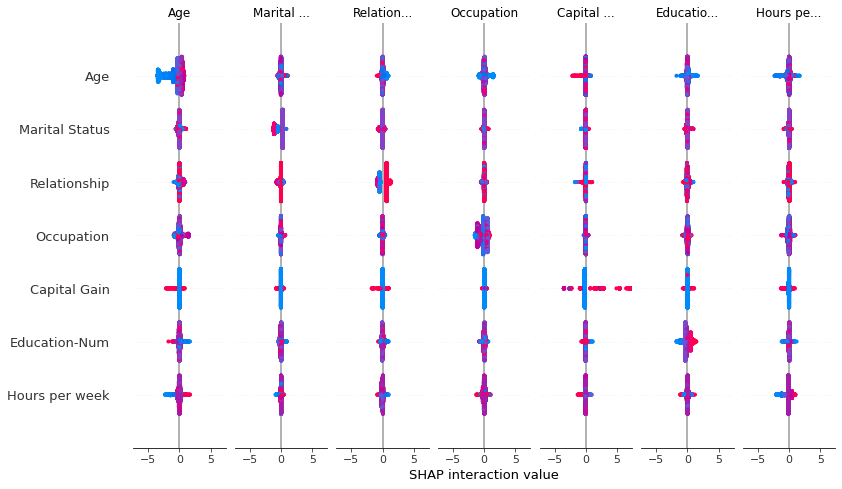

In [15]:
shap.summary_plot(shap_interaction_values, X_test)

In [18]:
# do some interaction calculation
shap_interaction_values.shape

(6513, 12, 12)

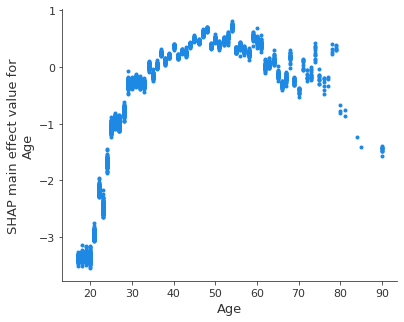

In [13]:
shap.dependence_plot(
    ("Age", "Age"),
    shap_interaction_values, X_test,
    display_features=X_display.loc[X_test.index, :]
)

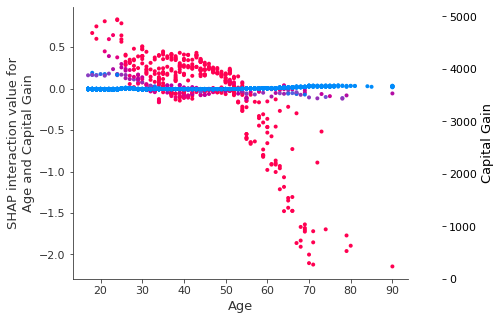

In [14]:
shap.dependence_plot(
    ("Age", "Capital Gain"),
    shap_interaction_values, X_test,
    display_features=X_display.loc[X_test.index, :]
)

# Boston

In [23]:
# https://archive.ics.uci.edu/ml/datasets/adult

seed = 7
X_display, y_display = shap.datasets.boston(display=True)
X, y = shap.datasets.boston(display=False)

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

params = {
    'eta': 0.02,
    'max_depth': 3,
    'objective': 'reg:squarederror',
    'subsample': 0.5,
    'seed': seed
}
model = xgboost.train(params, xgb_train, 10000, evals=[(xgb_test, "test")], verbose_eval=1000)

[0]	test-rmse:23.39558


Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datas

[1000]	test-rmse:3.47546
[2000]	test-rmse:3.53320
[3000]	test-rmse:3.57260
[4000]	test-rmse:3.58475
[5000]	test-rmse:3.59310
[6000]	test-rmse:3.59633
[7000]	test-rmse:3.59851
[8000]	test-rmse:3.60142
[9000]	test-rmse:3.60132
[9999]	test-rmse:3.60147


In [28]:
y_pred = model.predict(xgb_test)

print(f'# of train data: {xgb_train.num_row()}')
print(f'# of train data: {xgb_test.num_row()}')
print('R2 Score')
print(r2_score(y_true=y_test, y_pred=y_pred))

# of train data: 404
# of train data: 102
R2 Score
0.8394855718318671


In [29]:
explainer = shap.TreeExplainer(model, data=X_test)
shap_values = explainer.shap_values(X_test)

In [30]:
i = np.random.choice(np.arange(len(X_test)))
shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i, :])

In [32]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_test)

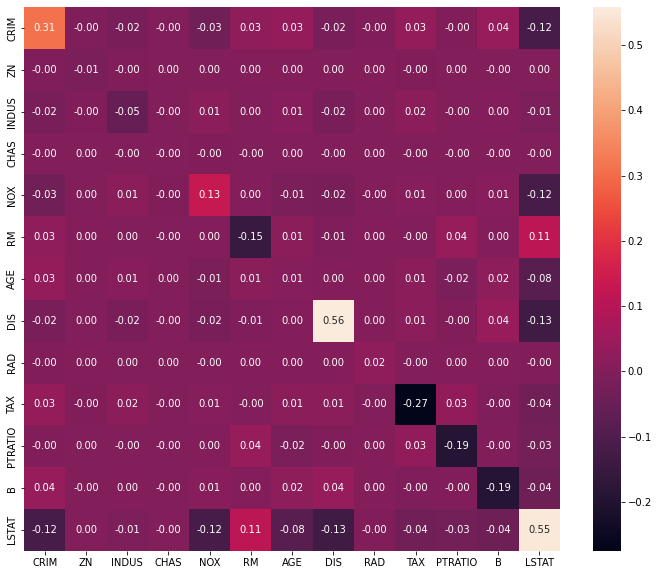

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(data=pd.DataFrame(shap_interaction_values.mean(0), index=X_test.columns, columns=X_test.columns), annot=True, fmt='.2f', ax=ax)
plt.show()

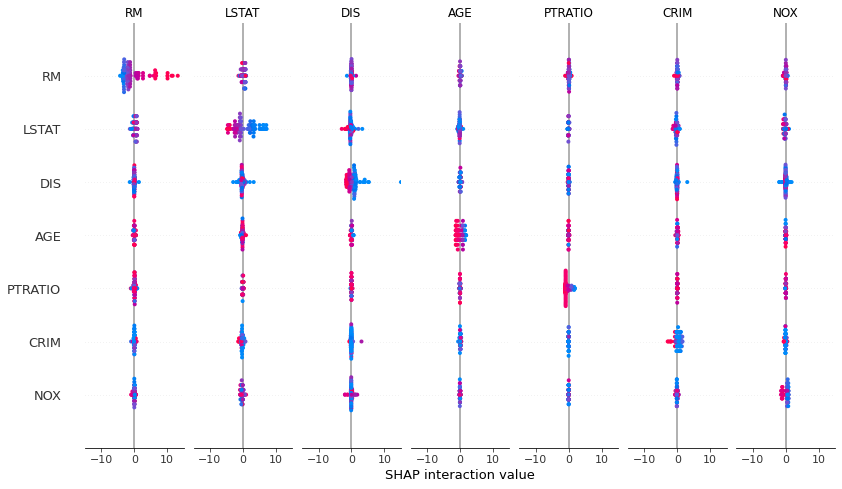

In [34]:
shap.summary_plot(shap_interaction_values, X_test)

In [35]:
X_test.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

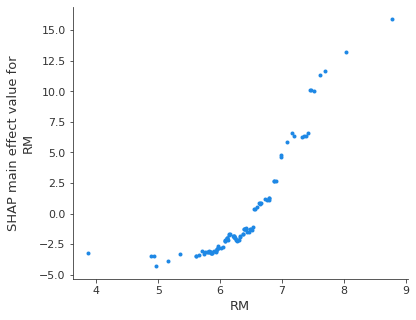

In [40]:
shap.dependence_plot(
    ("RM", "RM"),
    shap_interaction_values, X_test,
    display_features=X_display.loc[X_test.index, :]
)

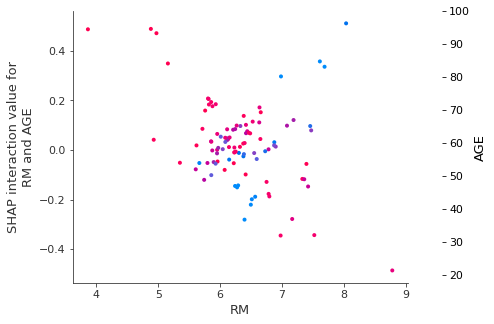

In [41]:
shap.dependence_plot(
    ("RM", "AGE"),
    shap_interaction_values, X_test,
    display_features=X_display.loc[X_test.index, :]
)

---

# Data Groupper in SHAP

- how to save the characteristic of each column data points?
- how to find the best grouper dynamically?

In [4]:
table_meta = X_display.dtypes.to_dict()

In [5]:
temp_X = X.copy()
for c_name, dtype in table_meta.items():
    if isinstance(dtype, pd.CategoricalDtype):
        pass 
    else:
        groups = pd.cut(X_display[c_name], bins=5, duplicates='drop')
        temp_X[f'G_{c_name}'] = groups

In [3]:
# How to Choosing a right reference data..?

metric = 'correlation'
refs = shap.sample(X.values, nsamples=100, random_state=0)
refs2 = shap.sample(X.values, nsamples=100, random_state=77)
masker = shap.maskers.Partition(data=refs, clustering=metric)
masker2 = shap.maskers.Partition(data=refs2, clustering=metric)
# masks out tabular features by integrating over the given background dataset.
# equals to:
bg_no_nan = refs.copy()
for i in range(bg_no_nan.shape[1]):
    np.nan_to_num(bg_no_nan[:,i], nan=np.nanmean(bg_no_nan[:,i]), copy=False)

# Computes the distance between m points using Euclidean distance (2-norm) as the distance metric between the points.
dist = sp.spatial.distance.pdist(bg_no_nan.T + np.random.randn(*bg_no_nan.T.shape)*1e-8, metric=metric)
cluster_matrix = sp.cluster.hierarchy.single(dist)

print((cluster_matrix.round(2) == masker.clustering.round(2)).all())

True


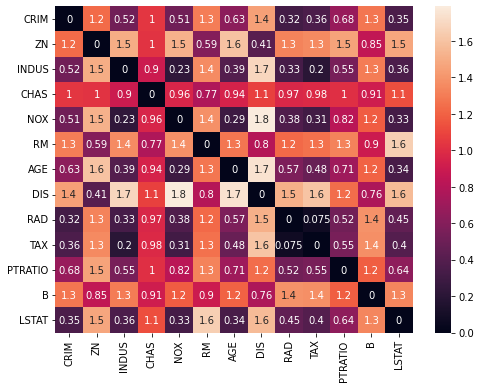

In [14]:
fig, ax  = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(data=pd.DataFrame(sp.spatial.distance.squareform(dist), columns=X.columns, index=X.columns), annot=True, ax=ax)
plt.show()

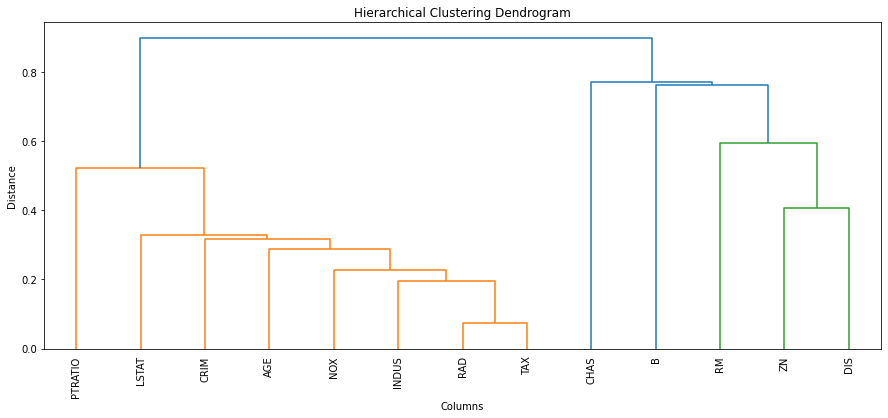

In [16]:
def plot_dendrogram(cols, cluster_matrix):
    plt.figure(figsize=(15, 6))
    plt.title(f'Hierarchical Clustering Dendrogram')
    plt.xlabel('Columns')
    plt.ylabel('Distance')
    sp.cluster.hierarchy.dendrogram(
        cluster_matrix,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=10.,  # font size for the x axis labels
        labels=cols
    )
    plt.show()

plot_dendrogram(cols=X.columns, cluster_matrix=cluster_matrix)

In [6]:
f = lambda x: model.predict(x, output_margin=True, validate_features=False)
explainer = shap.TreeExplainer(model, data=refs, feature_names=X.columns)
pexplainer = shap.PartitionExplainer(f, masker=masker, feature_names=X.columns)
pexplainer2 = shap.PartitionExplainer(f, masker=masker2, feature_names=X.columns)
pmexplainer = shap.PermutationExplainer(f, masker=masker, feature_names=X.columns)

shap_values = explainer(refs)
pshap_values = pexplainer(refs)
pshap_values2 = pexplainer2(refs2)
pmshap_values = pmexplainer(refs)

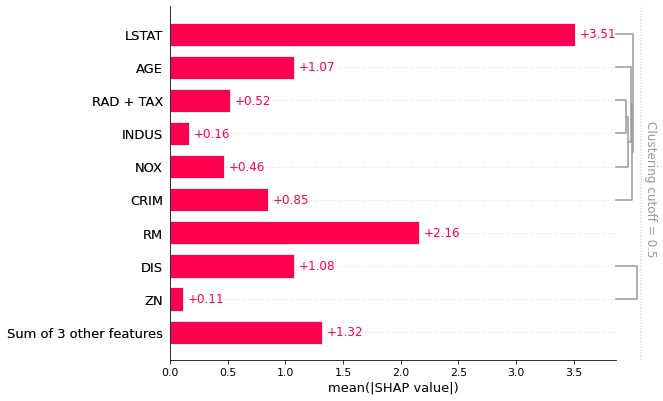

In [9]:
shap.plots.bar(pshap_values)

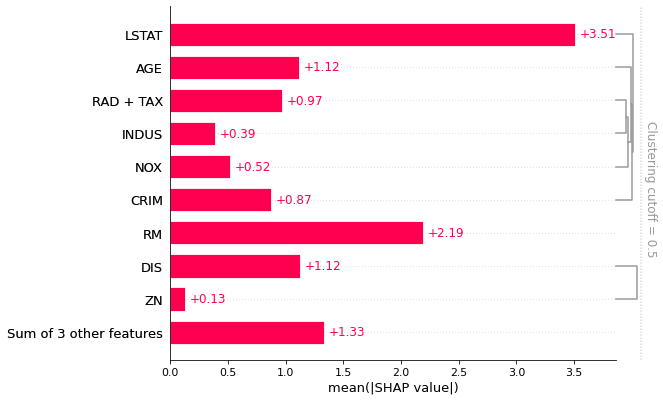

In [10]:
shap.plots.bar(pmshap_values)

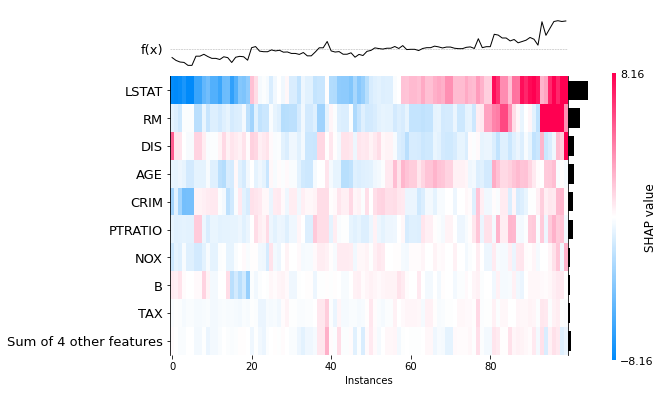

In [11]:
shap.plots.heatmap(pshap_values)

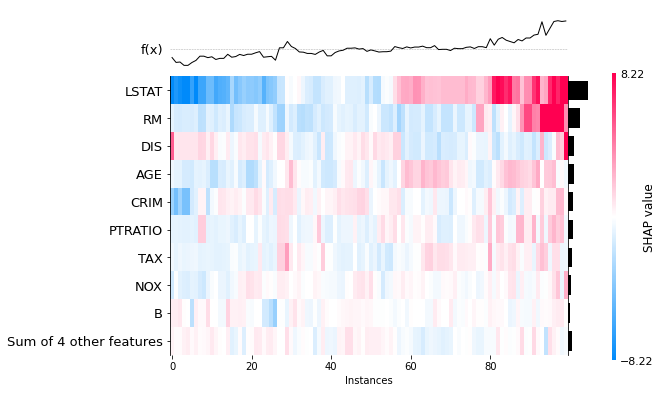

In [12]:
shap.plots.heatmap(pmshap_values)

In [13]:
shap.plots.force(pshap_values)

In [15]:
shap.plots.force(pshap_values2)

In [17]:
shap.plots.force(pmshap_values)